# Fusion Models on UCI Cleveland Heart Disease Dataset
# Concatenation-based vs Attention-based Fusion

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

In [3]:
# Load and preprocess data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
]

df = pd.read_csv(url, names=columns)
df = df.replace('?', np.nan).dropna()
df = df.apply(pd.to_numeric)
df["num"] = (df["num"] > 0).astype(int)

num_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

In [4]:
# Safe remapping of categorical variables to 0-based indices
for c in cat_cols:
    uniques = sorted(df[c].dropna().unique())
    mapping = {v: i for i, v in enumerate(uniques)}
    df[c] = df[c].map(mapping)
    df[c] = df[c].clip(0, len(uniques) - 1)  # avoids out-of-range errors

cat_cardinalities = [df[c].nunique() for c in cat_cols]
print("Cardinalities:", cat_cardinalities)

# Scale numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols])
X_cat = df[cat_cols].astype(int).values
y = df["num"].values

# Train/validation split
Xn_train, Xn_val, Xc_train, Xc_val, y_train, y_val = train_test_split(
    X_num, X_cat, y, test_size=0.2, stratify=y, random_state=42
)

class HeartDataset(Dataset):
    def __init__(self, Xn, Xc, y):
        self.Xn = torch.tensor(Xn, dtype=torch.float32)
        self.Xc = torch.tensor(Xc, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.Xn[i], self.Xc[i], self.y[i]

train_loader = DataLoader(HeartDataset(Xn_train, Xc_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(HeartDataset(Xn_val, Xc_val, y_val), batch_size=32, shuffle=False)

Cardinalities: [2, 4, 2, 3, 2, 3, 4, 3]


In [5]:
# Define models
class NumericTower(nn.Module):
    def __init__(self, in_dim, hidden=16, drop=0.30):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
        )
    def forward(self, x):
        return self.net(x)

class CategoricalTower(nn.Module):
    def __init__(self, cards, emb_dim=4, hidden=16, drop=0.30):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, emb_dim) for c in cards])
        self.net = nn.Sequential(
            nn.Linear(len(cards)*emb_dim, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
        )
    def forward(self, x):
        embs = [emb(x[:, i]) for i, emb in enumerate(self.embs)]
        h = torch.cat(embs, dim=1)
        return self.net(h)

class ConcatFusion(nn.Module):
    def __init__(self, num_in, cards, hidden=16, drop=0.30):
        super().__init__()
        self.num_tower = NumericTower(num_in, hidden, drop)
        self.cat_tower = CategoricalTower(cards, emb_dim=4, hidden=hidden, drop=drop)
        self.head = nn.Sequential(
            nn.Linear(2*hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, 1),
        )
    def forward(self, Xn, Xc):
        h = torch.cat([self.num_tower(Xn), self.cat_tower(Xc)], dim=1)
        return self.head(h).squeeze(1)

class AttentionFusion(nn.Module):
    def __init__(self, num_in, cards, hidden=16, drop=0.30):
        super().__init__()
        self.num_tower = NumericTower(num_in, hidden, drop)
        self.cat_tower = CategoricalTower(cards, emb_dim=4, hidden=hidden, drop=drop)
        # attention scores per branch
        self.score_num = nn.Linear(hidden, 1)
        self.score_cat = nn.Linear(hidden, 1)
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden//2, 1),
        )
    def forward(self, Xn, Xc):
        h_num = self.num_tower(Xn)
        h_cat = self.cat_tower(Xc)
        scores = torch.cat([self.score_num(h_num), self.score_cat(h_cat)], dim=1)
        attn = torch.softmax(scores, dim=1)
        fused = attn[:, :1]*h_num + attn[:, 1:2]*h_cat
        return self.head(fused).squeeze(1)

In [6]:
# Train & evaluate
def train_epoch(model, loader, opt, loss_fn, device):
    model.train()
    total = 0.0
    for Xn, Xc, y in loader:
        Xn, Xc, y = Xn.to(device), Xc.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(Xn, Xc)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        total += loss.item() * y.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def eval_auc(model, loader, device):
    model.eval()
    preds, labels = [], []
    for Xn, Xc, y in loader:
        Xn, Xc = Xn.to(device), Xc.to(device)
        prob = torch.sigmoid(model(Xn, Xc)).cpu().numpy()
        preds.append(prob)
        labels.append(y.numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    return roc_auc_score(labels, preds)

In [7]:
#Run
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

concat = ConcatFusion(Xn_train.shape[1], cat_cardinalities).to(device)
attn   = AttentionFusion(Xn_train.shape[1], cat_cardinalities).to(device)

loss_fn = nn.BCEWithLogitsLoss()
opt_c = torch.optim.Adam(concat.parameters(), lr=1e-3, weight_decay=1e-3)
opt_a = torch.optim.Adam(attn.parameters(),   lr=1e-3, weight_decay=1e-3)

best_c, best_a = 0.0, 0.0
patience, wait = 10, 0

print("\nTraining (dropout + weight decay + early stopping)...\n")
for epoch in range(1, 201):  # up to 200; early stopping will halt sooner
    lc = train_epoch(concat, train_loader, opt_c, loss_fn, device)
    la = train_epoch(attn,   train_loader, opt_a, loss_fn, device)
    auc_c = eval_auc(concat, val_loader, device)
    auc_a = eval_auc(attn,   val_loader, device)
    print(f"Epoch {epoch:03d} | Concat AUC={auc_c:.3f} | Attention AUC={auc_a:.3f}")

    improved = False
    if auc_c > best_c:
        best_c, improved = auc_c, True
    if auc_a > best_a:
        best_a, improved = auc_a, True
    if improved:
        wait = 0
    else:
        wait += 1
    if wait >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

Device: cuda

Training (dropout + weight decay + early stopping)...

Epoch 001 | Concat AUC=0.748 | Attention AUC=0.838
Epoch 002 | Concat AUC=0.864 | Attention AUC=0.881
Epoch 003 | Concat AUC=0.888 | Attention AUC=0.910
Epoch 004 | Concat AUC=0.901 | Attention AUC=0.927
Epoch 005 | Concat AUC=0.915 | Attention AUC=0.941
Epoch 006 | Concat AUC=0.922 | Attention AUC=0.943
Epoch 007 | Concat AUC=0.925 | Attention AUC=0.943
Epoch 008 | Concat AUC=0.926 | Attention AUC=0.939
Epoch 009 | Concat AUC=0.929 | Attention AUC=0.943
Epoch 010 | Concat AUC=0.926 | Attention AUC=0.943
Epoch 011 | Concat AUC=0.929 | Attention AUC=0.945
Epoch 012 | Concat AUC=0.929 | Attention AUC=0.950
Epoch 013 | Concat AUC=0.925 | Attention AUC=0.946
Epoch 014 | Concat AUC=0.926 | Attention AUC=0.946
Epoch 015 | Concat AUC=0.924 | Attention AUC=0.950
Epoch 016 | Concat AUC=0.921 | Attention AUC=0.950
Epoch 017 | Concat AUC=0.920 | Attention AUC=0.950
Epoch 018 | Concat AUC=0.921 | Attention AUC=0.949
Epoch 019 | C

In [8]:
# Compare
print("\n=== FINAL VALIDATION AUC (Best During Training) ===")
print(f"Concatenation Fusion: {best_c:.3f}")
print(f"Attention Fusion    : {best_a:.3f}")

if best_a > best_c:
    print("\nAttention-based fusion generalized better, likely due to adaptive weighting of numeric vs categorical branches plus regularization.")
elif best_c > best_a:
    print("\nConcatenation-based fusion performed better, suggesting simple joint representations were sufficient under stronger regularization.")
else:
    print("\nBoth fusion strategies performed similarly under regularization.")


=== FINAL VALIDATION AUC (Best During Training) ===
Concatenation Fusion: 0.929
Attention Fusion    : 0.950

Attention-based fusion generalized better, likely due to adaptive weighting of numeric vs categorical branches plus regularization.


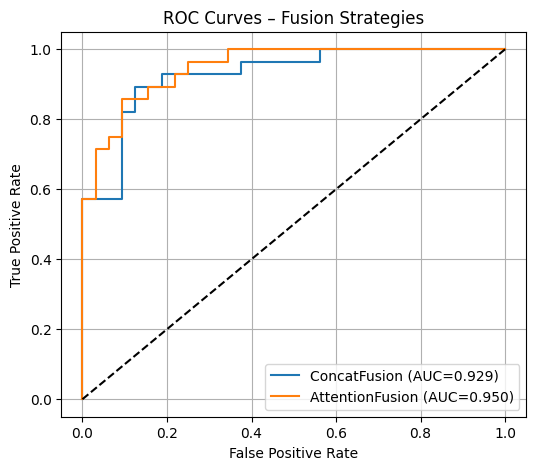

In [9]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(model, loader, device):
    model.eval()
    preds, labels = [], []
    for Xn, Xc, y in loader:
        Xn, Xc = Xn.to(device), Xc.to(device)
        out = torch.sigmoid(model(Xn, Xc))
        preds.append(out.cpu().numpy())
        labels.append(y.numpy())
    preds, labels = np.concatenate(preds), np.concatenate(labels)
    return labels, preds

# Compute ROC data
y_true_c, y_pred_c = get_preds(concat, val_loader, device)
y_true_a, y_pred_a = get_preds(attn, val_loader, device)
fpr_c, tpr_c, _ = roc_curve(y_true_c, y_pred_c)
fpr_a, tpr_a, _ = roc_curve(y_true_a, y_pred_a)

# Plot ROC curves
plt.figure(figsize=(6,5))
plt.plot(fpr_c, tpr_c, label=f'ConcatFusion (AUC={best_c:.3f})')
plt.plot(fpr_a, tpr_a, label=f'AttentionFusion (AUC={best_a:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Fusion Strategies')
plt.legend()
plt.grid(True)
plt.show()

Both fusion strategies achieved high predictive performance on the validation set, showing the effectiveness of combining structured and categorical information for heart disease classification.

The attention-based fusion model outperformed the concatenation-based model, with a higher validation AUC, indicating better generalization. This improvement is due to the attention mechanism’s ability to weight the contributions of numeric and categorical feature representations, allowing the model to use the most informative modality for each sample.

The concatenation-based model treats all feature embeddings equally, which limits its capacity to capture feature interactions.

In conclusion, the attention-based fusion provided a better integration of multimodal data, leading to superior validation performance.